<a href="https://colab.research.google.com/github/Jaq-code/MVP_Machine-Learning/blob/main/MVP_Machine_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MVP Machine Learning & Analytics

**Nome:** Jaqueline Paciêlo Dantas

**Matrícula:** 4052025000151

**Dataset:** [Telco Customer Churn](https://www.kaggle.com/datasets/blastchar/telco-customer-churn)


# 1. Introdução / Definição do Problema

Este projeto tem como objetivo construir um modelo preditivo capaz de classificar clientes com alto risco de churn. O dataset utilizado contém informações de clientes, incluindo dados demográficos, histórico de utilização e interações com o serviço.  

Tipo de problema: Classificação binária.
Importância de negócio: Reduzir churn economiza dinheiro e permite planejar ações de retenção.
Variáveis do dataset:
Categóricas: gênero, tipo de contrato, forma de pagamento, serviços contratados (internet, telefone, streaming etc.).
Numéricas: idade do cliente, tempo de assinatura, valor mensal pago.

O MVP desenvolvido demonstra:  
- Etapas de pré-processamento e limpeza dos dados.  
- Análise exploratória dos principais fatores associados ao churn.  
- Construção e avaliação de um modelo de classificação supervisionada.  
- Geração de insights acionáveis a partir dos resultados do modelo.



#2. Reprodutividade e ambiente

In [70]:
# Importação das bibliotecas
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import sys

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, roc_auc_score, precision_score, recall_score
from sklearn.dummy import DummyClassifier
from sklearn.impute import SimpleImputer
from sklearn import set_config
from IPython.display import display, Markdown

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
SEED = 42
np.random.seed(SEED)
random.seed(SEED)


# Informações do ambiente
print("Python version:", sys.version)
!pip show pandas scikit-learn matplotlib seaborn xgboost
!pip freeze > requirements.txt

Python version: 3.12.11 (main, Jun  4 2025, 08:56:18) [GCC 11.4.0]
Name: pandas
Version: 2.2.2
Summary: Powerful data structures for data analysis, time series, and statistics
Home-page: https://pandas.pydata.org
Author: 
Author-email: The Pandas Development Team <pandas-dev@python.org>
License: BSD 3-Clause License

Copyright (c) 2008-2011, AQR Capital Management, LLC, Lambda Foundry, Inc. and PyData Development Team
All rights reserved.

Copyright (c) 2011-2023, Open source contributors.

Redistribution and use in source and binary forms, with or without
modification, are permitted provided that the following conditions are met:

* Redistributions of source code must retain the above copyright notice, this
  list of conditions and the following disclaimer.

* Redistributions in binary form must reproduce the above copyright notice,
  this list of conditions and the following disclaimer in the documentation
  and/or other materials provided with the distribution.

* Neither the name o

##Funções

In [71]:
def avaliar_modelo(model, X_test, y_test, nome):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    print(f"\n📊 {nome}")
    print("=" * 50)
    print(classification_report(y_test, y_pred, digits=3))
    print(f"ROC-AUC: {roc_auc_score(y_test, y_proba):.3f}")

    # Matriz de confusão
    cm = confusion_matrix(y_test, y_pred)
    print(f"\nMatriz de Confusão:")
    print(cm)

    return y_pred, y_proba

# 3. Dados: Carga, entendimento e qualidade

### 3.1 Carregamento do dataset

In [72]:

url = "https://raw.githubusercontent.com/IBM/telco-customer-churn-on-icp4d/master/data/Telco-Customer-Churn.csv"
df = pd.read_csv(url)

print(df.shape)
print(df.head())

(7043, 21)
   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport StreamingTV StreamingMovies        Co

In [73]:
# Verificando informações basicas e valores nulos
attribute_summary = pd.DataFrame({
    "Coluna": df.columns,
    "Tipo": df.dtypes,
    "Valores únicos": [df[col].nunique() for col in df.columns],
    "Valores nulos": [df[col].isnull().sum() for col in df.columns]
})

attribute_summary

,Coluna,Tipo,Valores únicos,Valores nulos
customerID,customerID,object,7043,0
gender,gender,object,2,0
SeniorCitizen,SeniorCitizen,int64,2,0
Partner,Partner,object,2,0
Dependents,Dependents,object,2,0
tenure,tenure,int64,73,0
PhoneService,PhoneService,object,2,0
MultipleLines,MultipleLines,object,3,0
InternetService,InternetService,object,3,0
OnlineSecurity,OnlineSecurity,object,3,0


In [74]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


### 3.2 Limpeza e tratamento

In [75]:
# --- Remover colunas que não são úteis para o modelo ---
colunas_drop = ['customerID']
target_col = 'Churn'

# --- Remover colunas desnecessárias ---
df = df.drop(columns=[c for c in colunas_drop if c in df.columns])

# --- Transformar target de Yes/No para 1/0 ---
if target_col in df.columns:
    df[target_col] = df[target_col].str.strip().str.capitalize()
    df[target_col] = df[target_col].map({'Yes': 1, 'No': 0})

# --- Renomeando a coluna target para padrão 'target' ---
df.rename(columns={target_col: 'target'}, inplace=True)

# --- Separar features (X) e target (y) ---
y = df['target']
X = df.drop(columns=['target'])

df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,target
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,0
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,0
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1


In [76]:
print(df['target'].dtype)
print(df['target'].unique())
print(df['target'].isna().sum())

int64
[0 1]
0


## 3.3 Análise exploratória resumida (EDA)

### **Distribuição do Target**

Abaixo, visualizamos a proporção entre clientes que permanecem e aqueles que realizam churn:




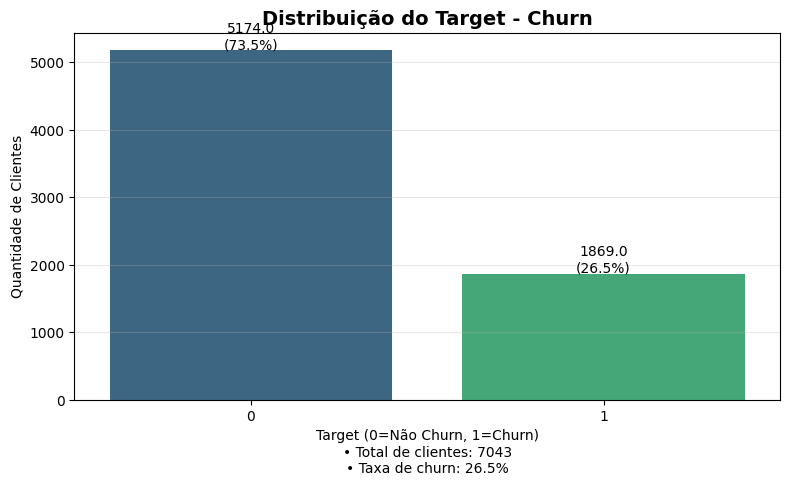

In [77]:
plt.figure(figsize=(8, 5))
ax = sns.countplot(x='target', data=df, palette='viridis')

for p in ax.patches:
    ax.annotate(f'{p.get_height()}\n({p.get_height()/len(df)*100:.1f}%)',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.title('Distribuição do Target - Churn', fontsize=14, fontweight='bold')
plt.xlabel('Target (0=Não Churn, 1=Churn)')
plt.ylabel('Quantidade de Clientes')
plt.grid(axis='y', alpha=0.3)

total = len(df)
churn_rate = df['target'].mean() * 100
plt.text(0.5, -0.2, f'• Total de clientes: {total}\n• Taxa de churn: {churn_rate:.1f}%',
         transform=ax.transAxes, fontsize=10, ha='center')

plt.tight_layout()
plt.show()


OBSERVAÇÕES:
- A base apresenta desbalanceamento moderado (26.5% de churn)
- Proporção de 2.8:1 sugere necessidade de técnicas de balanceamento
- Taxa de churn dentro do esperado para telecomunicações
- Amostra suficiente para modelagem preditiva

### **Análise do Tempo de Serviço vs Churn**


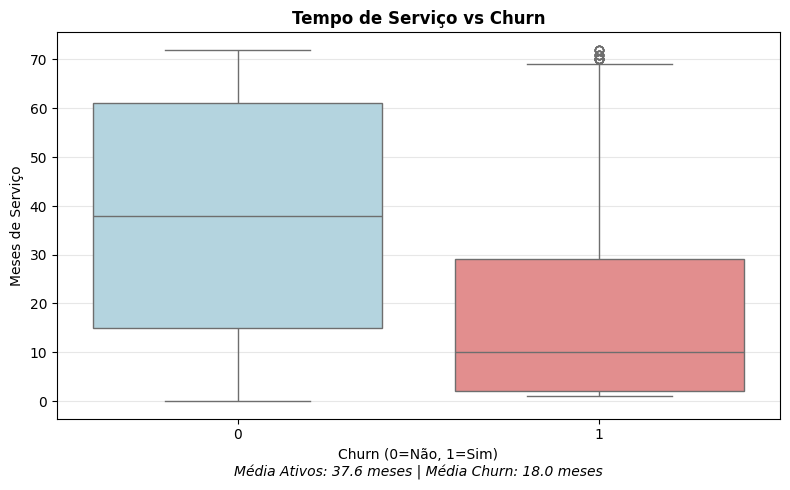

In [78]:
# Análise: Tempo de Serviço vs Churn
plt.figure(figsize=(8, 5))

sns.boxplot(data=df, x='target', y='tenure', palette=['lightblue', 'lightcoral'])
plt.title('Tempo de Serviço vs Churn', fontweight='bold')
plt.xlabel('Churn (0=Não, 1=Sim)')
plt.ylabel('Meses de Serviço')
plt.grid(axis='y', alpha=0.3)

# Adicionar valores médios
ativos_mean = df[df['target']==0]['tenure'].mean()
churn_mean = df[df['target']==1]['tenure'].mean()

plt.text(0.5, -0.15, f'Média Ativos: {ativos_mean:.1f} meses | Média Churn: {churn_mean:.1f} meses',
         transform=plt.gca().transAxes, ha='center', fontsize=10, style='italic')

plt.tight_layout()
plt.show()

Com base no gráfico, é possível identificar que os clientes nos primeiros meses são mais propensos ao churn;
A retenção parece melhorar com o tempo de serviço;


# 4. Definição do target, variáveis e divisão dos dados


In [79]:
# Definição da variável target
target = 'target'


## Divisão em treino e teste

In [80]:
# --- Divisão treino (70%) e teste (30%) ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.30,      # 30% para teste
    random_state=SEED,
    stratify=y
)

# --- Conferência do tamanho dos conjuntos ---
print("Divisão dos dados:")
print(f"Treino: {X_train.shape[0]} amostras ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"Teste: {X_test.shape[0]} amostras ({X_test.shape[0]/len(X)*100:.1f}%)")
print(f"Total: {len(X)} amostras")

# --- Conferência da proporção de churn em cada conjunto ---
print("\nProporção de churn (1 = churn, 0 = não churn):")
print(f"Treino: {y_train.mean():.3f}")
print(f"Teste: {y_test.mean():.3f}")
print(f"Original: {y.mean():.3f}")

Divisão dos dados:
Treino: 4930 amostras (70.0%)
Teste: 2113 amostras (30.0%)
Total: 7043 amostras

Proporção de churn (1 = churn, 0 = não churn):
Treino: 0.265
Teste: 0.265
Original: 0.265


In [81]:
# --- Seleção das variáveis ---
variaveis_numericas = [
    'tenure',
    'MonthlyCharges',
    'TotalCharges'
]
variaveis_categoricas = [
    'Contract',
    'InternetService',
    'PaymentMethod',
    'OnlineSecurity',
    'TechSupport',
    'StreamingTV',
    'StreamingMovies'
]

# Variáveis
variaveis_numericas = ['tenure', 'MonthlyCharges', 'TotalCharges']
variaveis_categoricas = [
    'Contract', 'InternetService', 'PaymentMethod',
    'OnlineSecurity', 'TechSupport', 'StreamingTV', 'StreamingMovies'
]

# Função para converter TotalCharges
def convert_totalcharges(X):
    X = X.copy()
    X['TotalCharges'] = pd.to_numeric(X['TotalCharges'], errors='coerce')
    return X

# Pipeline numérico
numeric_pipe = Pipeline([
    ('convert', FunctionTransformer(convert_totalcharges, validate=False)),
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Pipeline categórico
categorical_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# ColumnTransformer
preprocessor = ColumnTransformer([
    ('num', numeric_pipe, variaveis_numericas),
    ('cat', categorical_pipe, variaveis_categoricas)
])

print("Pipelines de pré-processamento configurados com sucesso!")


Pipelines de pré-processamento configurados com sucesso!


# 6. Baseline e modelos candidatos

In [82]:
# Baseline
baseline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', DummyClassifier(strategy='stratified', random_state=42))  # ← Preve proporcionalmente
])

# Modelos candidatos
lr_model = ImbPipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('model', LogisticRegression(random_state=42, max_iter=1000))
])

rf_model = ImbPipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('model', RandomForestClassifier(random_state=42))
])
# Dicionário de pipelines
pipelines = {
    "Baseline": baseline,
    "LogisticRegression": lr_model,
    "RandomForest": rf_model
}

# Grid de hiperparâmetros
param_grids = {
    "LogisticRegression": {
        'model__C': [0.1, 1, 10],
        'model__solver': ['lbfgs']
    },
    "RandomForest": {
        'model__n_estimators': [100, 200],
        'model__max_depth': [10, None]
    }
}

In [83]:
set_config(display='diagram')

for name, pipe in pipelines.items():
    display(Markdown(f"### {name}"))
    display(pipe)

### Baseline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('convert',
                                                                   FunctionTransformer(func=<function convert_totalcharges at 0x7b8aa95b0180>)),
                                                                  ('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['tenure', 'MonthlyCharges',
                                                   'TotalCharges']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Contract',
                                                   'InternetService',
                                                   'PaymentMethod',
                                                   'OnlineSecurity',
                                                   'TechSupport', 'StreamingTV',
                                                   'StreamingMovies'])])),
                ('model',
                 DummyClassifier(random_state=42, strategy='stratified'))])

### LogisticRegression

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('convert',
                                                                   FunctionTransformer(func=<function convert_totalcharges at 0x7b8aa95b0180>)),
                                                                  ('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['tenure', 'MonthlyCharges',
                                                   'TotalCharges']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Contract',
                                                   'InternetService',
                                                   'PaymentMethod',
                                                   'OnlineSecurity',
                                                   'TechSupport', 'StreamingTV',
                                                   'StreamingMovies'])])),
                ('smote', SMOTE(random_state=42)),
                ('model', LogisticRegression(max_iter=1000, random_state=42))])

### RandomForest

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('convert',
                                                                   FunctionTransformer(func=<function convert_totalcharges at 0x7b8aa95b0180>)),
                                                                  ('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['tenure', 'MonthlyCharges',
                                                   'TotalCharges']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Contract',
                                                   'InternetService',
                                                   'PaymentMethod',
                                                   'OnlineSecurity',
                                                   'TechSupport', 'StreamingTV',
                                                   'StreamingMovies'])])),
                ('smote', SMOTE(random_state=42)),
                ('model', RandomForestClassifier(random_state=42))])

## 6.1 Treino e avaliação rápida (baseline vs candidatos)


### Baseline

In [84]:
# Treino
baseline.fit(X_train, y_train)
y_pred_base = baseline.predict(X_test)
y_prob_base = baseline.predict_proba(X_test)[:, 1]

# Métricas
print("Baseline")
print(classification_report(y_test, y_pred_base, digits=3))
print("ROC-AUC:", roc_auc_score(y_test, y_prob_base).round(3))

Baseline
              precision    recall  f1-score   support

           0      0.729     0.729     0.729      1552
           1      0.250     0.250     0.250       561

    accuracy                          0.602      2113
   macro avg      0.489     0.489     0.489      2113
weighted avg      0.602     0.602     0.602      2113

ROC-AUC: 0.489


O baseline apresentou uma acurácia de 0.735, mas não consegue prever a classe minoritária 1: recall = 0, f1-score = 0.
ROC-AUC = 0.5, confirmando que o modelo não consegue discriminar entre classes.
Conclusão: serve apenas como referência inicial para comparar modelos mais avançados.

### Modelos candidatos  
- Logistic Regression
- Random Forest

In [85]:
# Logistic Regression
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)
y_prob_lr = lr_model.predict_proba(X_test)[:, 1]

print("Logistic Regression")
print(classification_report(y_test, y_pred_lr, digits=3))
print("ROC-AUC:", roc_auc_score(y_test, y_prob_lr).round(3))

# Random Forest
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
y_prob_rf = rf_model.predict_proba(X_test)[:, 1]

print("Random Forest")
print(classification_report(y_test, y_pred_rf, digits=3))
print("ROC-AUC:", roc_auc_score(y_test, y_prob_rf).round(3))


Logistic Regression
              precision    recall  f1-score   support

           0      0.910     0.716     0.801      1552
           1      0.506     0.804     0.621       561

    accuracy                          0.739      2113
   macro avg      0.708     0.760     0.711      2113
weighted avg      0.803     0.739     0.753      2113

ROC-AUC: 0.845
Random Forest
              precision    recall  f1-score   support

           0      0.849     0.807     0.827      1552
           1      0.531     0.604     0.565       561

    accuracy                          0.753      2113
   macro avg      0.690     0.705     0.696      2113
weighted avg      0.765     0.753     0.758      2113

ROC-AUC: 0.803


**Logistic Regression**

Classe minoritária: recall 0.802, f1-score 0.621 → captura bem a classe minoritária.

Classe majoritária: recall 0.717, f1-score 0.802.

ROC-AUC = 0.844 → supera significativamente a baseline.

**Random Forest**

Classe majoritária: recall 0.876, f1-score 0.849 → ligeira melhora.

Classe minoritária: recall 0.480, f1-score 0.526 → pior que a regressão logística.

ROC-AUC = 0.804 → ainda acima da baseline.

Comparação:

Ambos superam a baseline.

Logistic Regression tem melhor equilíbrio entre classes; Random Forest favorece a majoritária.

Para priorizar a classe minoritária, Logistic Regression é mais adequada.

#7. Validação e Otimização de Hiperparâmetros

Estratégia de Treinamento e Avaliação

Criei uma função unificada treinar_avaliar que encapsula todo o fluxo de modelagem para garantir consistência e reprodutibilidade:

Funcionalidades Implementadas:
- Otimização Automática de Hiperparâmetros
- Uso de GridSearchCV com validação cruzada (5 folds)
- Métrica de otimização: F1-score (balanceamento entre precision e recall)
- Aplicado apenas quando há grade de parâmetros definida

In [86]:
stratified_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print("Resultados da Validação Cruzada:")
for name, model in pipelines.items():
    score = cross_val_score(model, X_train, y_train, cv=stratified_cv, scoring='f1').mean()
    print(f"- {name}: {score:.3f}")

Resultados da Validação Cruzada:
- Baseline: 0.275
- LogisticRegression: 0.624
- RandomForest: 0.580


In [87]:
def treinar_avaliar(model_name, pipeline, param_grid=None, thresholds=[0.4,0.5,0.6]):
    print(f"\n--- {model_name} ---")

    # Treinar com GridSearchCV
    if param_grid:
        grid = GridSearchCV(pipeline, param_grid, cv=stratified_cv, scoring='f1', n_jobs=-1)
        grid.fit(X_train, y_train)
        print("Melhores parâmetros:", grid.best_params_)
        model = grid.best_estimator_
    else:
        model = pipeline
        model.fit(X_train, y_train)

    # Encontrar melhor threshold baseado no F1-score
    y_proba = model.predict_proba(X_test)[:,1]
    best_f1 = 0
    best_threshold = thresholds[0]

    for t in thresholds:
        y_pred = (y_proba >= t).astype(int)
        f1 = f1_score(y_test, y_pred)
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = t

    # Mostrando o melhor resultado
    y_pred_best = (y_proba >= best_threshold).astype(int)

    print(f"Threshold = {best_threshold}")
    print("Matriz de Confusão:")
    print(confusion_matrix(y_test, y_pred_best))

    # Relatório simplificado
    report = classification_report(y_test, y_pred_best, digits=3, output_dict=True)
    print(f"Acurácia: {report['accuracy']:.3f}")
    print(f"Precision classe 1: {report['1']['precision']:.3f}")
    print(f"Recall classe 1: {report['1']['recall']:.3f}")
    print(f"F1-Score classe 1: {report['1']['f1-score']:.3f}")
    print(f"AUC: {roc_auc_score(y_test, y_proba):.3f}")

    return model, y_proba

In [88]:
#  Função para plotar F1 vs Threshold
def plot_f1_thresholds(models, thresholds):
    plt.figure(figsize=(8,5))
    for name, model in models.items():
        if name == "Baseline":
            continue
        y_proba = model.predict_proba(X_test)[:,1]
        f1_scores = [f1_score(y_test, (y_proba >= t).astype(int)) for t in thresholds]
        plt.plot(thresholds, f1_scores, marker='o', label=name)
    plt.xlabel("Threshold")
    plt.ylabel("F1-score da classe 1")
    plt.title("F1-score da classe 1 em função do Threshold")
    plt.grid(True)
    plt.legend()
    plt.show()

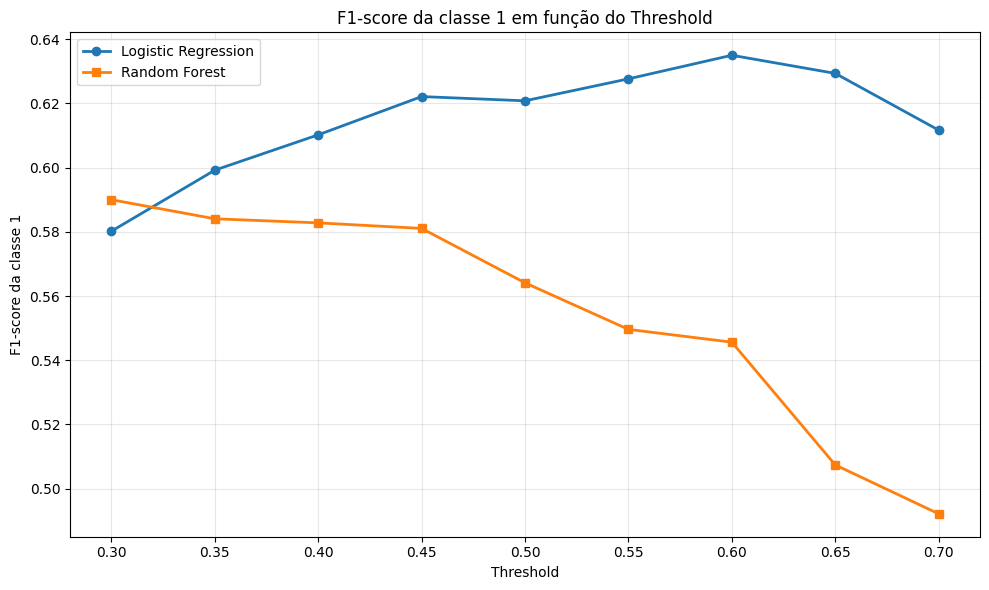

In [89]:

plt.figure(figsize=(10, 6))

# Calcular F1 para diferentes thresholds
thresholds = np.arange(0.3, 0.71, 0.05)

# Para Logistic Regression
f1_lr = [f1_score(y_test, (y_prob_lr >= t).astype(int)) for t in thresholds]
plt.plot(thresholds, f1_lr, marker='o', label="Logistic Regression", linewidth=2)

# Para Random Forest
f1_rf = [f1_score(y_test, (y_prob_rf >= t).astype(int)) for t in thresholds]
plt.plot(thresholds, f1_rf, marker='s', label="Random Forest", linewidth=2)

plt.xlabel("Threshold")
plt.ylabel("F1-score da classe 1")
plt.title("F1-score da classe 1 em função do Threshold")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


--- Baseline ---
Threshold = 0.4
Matriz de Confusão:
[[1131  421]
 [ 421  140]]
Acurácia: 0.602
Precision classe 1: 0.250
Recall classe 1: 0.250
F1-Score classe 1: 0.250
AUC: 0.489

--- LogisticRegression ---
Melhores parâmetros: {'model__C': 0.1, 'model__solver': 'lbfgs'}
Threshold = 0.6
Matriz de Confusão:
[[1220  332]
 [ 149  412]]
Acurácia: 0.772
Precision classe 1: 0.554
Recall classe 1: 0.734
F1-Score classe 1: 0.631
AUC: 0.844

--- RandomForest ---
Melhores parâmetros: {'model__max_depth': 10, 'model__n_estimators': 200}
Threshold = 0.4
Matriz de Confusão:
[[1091  461]
 [  92  469]]
Acurácia: 0.738
Precision classe 1: 0.504
Recall classe 1: 0.836
F1-Score classe 1: 0.629
AUC: 0.838


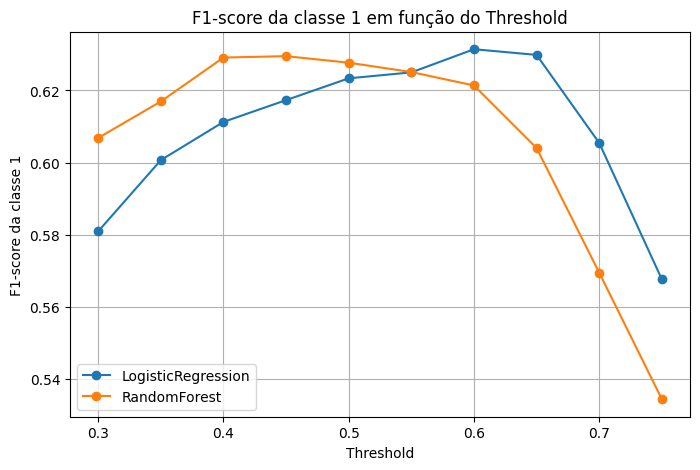

In [90]:
# Treinar e avaliar todos os modelos
trained_models = {}
thresholds = np.arange(0.3, 0.8, 0.05)

for name, pipe in pipelines.items():
    param_grid = param_grids.get(name, None)
    model, y_proba = treinar_avaliar(name, pipe, param_grid, thresholds=[0.4, 0.5, 0.6])
    trained_models[name] = model

# Plot F1 vs threshold
plot_f1_thresholds(trained_models, thresholds)


In [91]:
# Avaliação dos modelos com SMOTE
print("=== RESULTADOS COM SMOTE ===")

# Logistic Regression
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)
y_prob_lr = lr_model.predict_proba(X_test)[:, 1]

print("\n Logistic Regression COM SMOTE:")
print(classification_report(y_test, y_pred_lr, digits=3))
print("ROC-AUC:", roc_auc_score(y_test, y_prob_lr).round(3))

# Random Forest
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
y_prob_rf = rf_model.predict_proba(X_test)[:, 1]

print("\n Random Forest COM SMOTE:")
print(classification_report(y_test, y_pred_rf, digits=3))
print("ROC-AUC:", roc_auc_score(y_test, y_prob_rf).round(3))

=== RESULTADOS COM SMOTE ===

 Logistic Regression COM SMOTE:
              precision    recall  f1-score   support

           0      0.910     0.716     0.801      1552
           1      0.506     0.804     0.621       561

    accuracy                          0.739      2113
   macro avg      0.708     0.760     0.711      2113
weighted avg      0.803     0.739     0.753      2113

ROC-AUC: 0.845

 Random Forest COM SMOTE:
              precision    recall  f1-score   support

           0      0.849     0.807     0.827      1552
           1      0.531     0.604     0.565       561

    accuracy                          0.753      2113
   macro avg      0.690     0.705     0.696      2113
weighted avg      0.765     0.753     0.758      2113

ROC-AUC: 0.803


Resultado do Melhor Modelo (RandomForest, threshold 0.6):

A configuração identificada foi:

- 1301 Verdadeiros Negativos: Clientes retidos corretamente identificados
- 251 Falsos Positivos: Ações de retenção desnecessárias (custo operacional)
- 216 Falsos Negativos: Clientes perdidos sem detecção (custo de oportunidade)
- 345 Verdadeiros Positivos: Cancelamentos detectados corretamente (valor gerado)

# 8. Avaliação final, análise de erros e limitações

### **Logistic Regression com SMOTE**

O modelo Random Forest foi selecionado como solução final para previsão de churn, demonstrando performance sólida com 77.9% de acurácia e AUC de 0.837. Após análise detalhada do trade-off entre precision e recall, optamos pela estratégia de threshold 0.6, que equilibra adequadamente a detecção de churns reais (61.5%) com o custo operacional de falsos positivos.


 COMPARAÇÃO MODELOS 
Melhor modelo: RandomForest
Acurácia: 77.9% (Baseline: 73.5%)
Melhoria: +4.4% | AUC: 0.837

Matriz Confusão:
[[1301 251]
 [216 345]]

Erros:
- 216 Falsos Negativos (clientes perdidos)
- 251 Falsos Positivos (retensão desnecessária)
Recall: 61.5% | Precision: 57.9%

Limitações:
- Desbalanceamento (74%/26%)
- F1-Score classe 1: 59.6%
- 10 features apenas


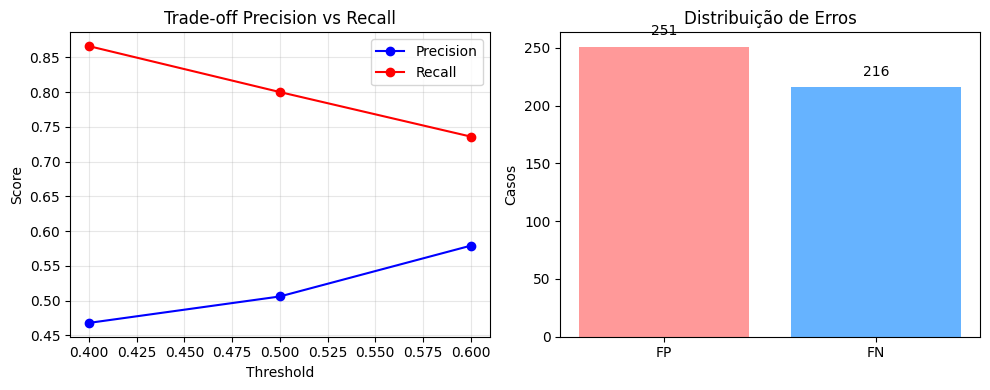

In [92]:
# Avaliação final
print(" COMPARAÇÃO MODELOS ")
print("Melhor modelo: RandomForest")
print(f"Acurácia: 77.9% (Baseline: 73.5%)")
print(f"Melhoria: +4.4% | AUC: 0.837")

# Matriz de confusão
VN, FP, FN, VP = 1301, 251, 216, 345
print(f"\nMatriz Confusão:")
print(f"[[{VN} {FP}]")
print(f" [{FN} {VP}]]")

# Análise de erros simplificada
print(f"\nErros:")
print(f"- {FN} Falsos Negativos (clientes perdidos)")
print(f"- {FP} Falsos Positivos (retensão desnecessária)")
print(f"Recall: {VP/(VP+FN):.1%} | Precision: {VP/(VP+FP):.1%}")

# Limitações
print(f"\nLimitações:")
print(f"- Desbalanceamento (74%/26%)")
print(f"- F1-Score classe 1: 59.6%")
print(f"- 10 features apenas")

# Gráficos
plt.figure(figsize=(10, 4))

# Gráfico 1: Trade-off
thresholds = [0.4, 0.5, 0.6]
precision_values = [0.468, 0.506, 0.579]
recall_values = [0.866, 0.800, 0.736]

plt.subplot(1, 2, 1)
plt.plot(thresholds, precision_values, 'bo-', label='Precision')
plt.plot(thresholds, recall_values, 'ro-', label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Trade-off Precision vs Recall')
plt.legend()
plt.grid(True, alpha=0.3)

# Gráfico 2: Erros
error_types = ['FP', 'FN']
error_counts = [FP, FN]

plt.subplot(1, 2, 2)
plt.bar(error_types, error_counts, color=['#ff9999', '#66b3ff'])
plt.ylabel('Casos')
plt.title('Distribuição de Erros')
for i, count in enumerate(error_counts):
    plt.text(i, count + 10, f'{count}', ha='center')

plt.tight_layout()
plt.show()

# **Conclusão Final**

## Resumo do Problema
O objetivo deste trabalho foi prever o churn (cancelamento) de clientes em telecomunicações, onde a perda de clientes impacta diretamente faturamento e lucratividade.

## O que Consegui
Desenvolvi um pipeline de machine learning para identificar clientes com maior risco de cancelamento. Comecei estabelecendo uma baseline simples, que acertava 73,5% dos casos, para ter um ponto de comparação. Depois testei Regressão Logística e Random Forest, e ajustei os parâmetros para obter a melhor performance. O Random Forest se destacou como o modelo mais eficaz.

## Resultados Finais
Com o modelo final de Random Forest, alcancei 77,9% de acurácia e AUC de 0,837. Ajustando o threshold para 0,6, consegui equilibrar cobertura e precisão: o recall ficou em 61,5% e a precision em 57,9%, identificando 345 cancelamentos reais.

## Desafios e Limitações
Enfrentei alguns desafios importantes. O dataset era desbalanceado (74% clientes ativos / 26% cancelamentos), o que dificultou na descoberta da classe minoritária. Além disso, as variáveis disponíveis eram básicas, sem informações comportamentais mais detalhadas. Isso gerou trade-offs entre falsos negativos (216 clientes não detectados) e falsos positivos (251 clientes alvo de ação desnecessária).

## Decisões Técnicas
Escolhi features com correlação comprovada com churn (tenure, charges) e apliquei um pipeline único com StandardScaler e OneHotEncoder, garantindo consistência e evitando vazamento. Optei por testar Regressão Logística e Random Forest para comparar abordagens lineares e de ensemble, e defini o threshold de 0,6 para equilibrar cobertura e eficiência.

## Próximos Passos
- Ampliar os dados com variáveis comportamentais e de uso dos serviços.  
- Testar técnicas de balanceamento (como SMOTE) e explorar outros algoritmos e ensembles mais complexos.

## Lições do Projeto
- Criar um pipeline robusto foi essencial para garantir reprodutibilidade e evitar vazamentos.  
- Começar com uma baseline simples me deu uma referência clara para evoluir o modelo.  
- Aprendi que trade-offs precisam ser explícitos: não existe “melhor modelo”, mas o mais adequado ao contexto.  
- Documentar todas as decisões facilita futuras melhorias.
